In [286]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from analyzer.metric import MetricCalculator
from analyzer.model.regression_model import RegressionModel
from data.io import Reader
from data.plot import Drawer
from analyzer.stat_criterion.stat_criteria import StatCriteria
from data.encoder import Encoder
from data.normalizer import Normalizer
from data import DataPreparation

from keras.src.layers import Dense
from keras import Sequential, Input

# Постановка задачи
1. Провести анализ датасета 
2. Построить модель для предсказания price

датасет:
https://raw.githubusercontent.com/Semendyeav/datasets/refs/heads/main/PDA120_SVM_Furniture_Price.csv

# Проверка целостности датасета

In [287]:
# читаем датасет в память из внешнего источника
df_original = Reader.read_csv("https://raw.githubusercontent.com/Semendyeav/datasets/refs/heads/main/PDA120_SVM_Furniture_Price.csv")
df = df_original.copy().reset_index(drop=True)
df.head(10)

price        cost  sales  profit_margin  inventory  \
0  157.779576  118.103101     49      25.146775         31   
1   90.105994   78.154247     16      13.264098         80   
2  315.632724  209.730562      5      33.552339        197   
3  243.943349  139.551076     28      42.793654         60   
4  176.307447  155.390535     49      11.863885          8   
5  170.904812  123.967196      3      27.464186         14   
6   70.450871   36.681478     29      47.933251         46   
7  159.084380  100.334044     10      36.930298        186   
8  242.198505  214.498593     27      11.436863        114   
9  185.395239  140.466499     21      24.234031         72   

   discount_percentage  delivery_days category material  color  location  \
0            18.005458              4    Table     Wood  Black     Urban   
1            26.080585              1     Sofa    Metal  Black  Suburban   
2            12.843407              2    Table     Wood  Black     Rural   
3             0.536206              7     Desk     Wood    Red     Urban   
4            15.954705              8    Chair  Plastic   Blue     Urban   
5            23.798942              6     Sofa    Metal  Black     Urban   
6            27.405329              6    Chair    Metal    Red  Suburban   
7            15.944578              2    Table    Glass  Green     Urban   
8             5.099694              9    Chair  Plastic  Brown     Urban   
9            25.001329              1    Chair    Metal    Red     Urban   

   season store_type   brand       revenue  
0  Winter     Retail  BrandA   9143.085733  
1  Spring     Retail  BrandD   -758.398851  
2  Summer     Online  BrandA -10614.700410  
3  Winter     Retail  BrandA   3557.354633  
4  Spring     Retail  BrandA   5766.781188  
5    Fall     Online  BrandA  13012.328660  
6    Fall     Online  BrandA   1344.957278  
7  Winter     Retail  BrandD    624.454280  
8  Summer     Retail  BrandC   9588.721917  
9    Fall     Retail  BrandD  11465.199206

In [288]:
# смотрим на типы данных и требования к памяти
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   price                2500 non-null   float64
 1   cost                 2500 non-null   float64
 2   sales                2500 non-null   int64  
 3   profit_margin        2500 non-null   float64
 4   inventory            2500 non-null   int64  
 5   discount_percentage  2500 non-null   float64
 6   delivery_days        2500 non-null   int64  
 7   category             2500 non-null   object 
 8   material             2500 non-null   object 
 9   color                2500 non-null   object 
 10  location             2500 non-null   object 
 11  season               2500 non-null   object 
 12  store_type           2500 non-null   object 
 13  brand                2500 non-null   object 
 14  revenue              2500 non-null   float64
dtypes: float64(5), int64(3), object(7)
mem

In [289]:
# посмотрим на пропуски в данных
df.isna().sum()

price                  0
cost                   0
sales                  0
profit_margin          0
inventory              0
discount_percentage    0
delivery_days          0
category               0
material               0
color                  0
location               0
season                 0
store_type             0
brand                  0
revenue                0
dtype: int64

In [290]:
# Посмотрим статистику о датасете
df.describe()

price         cost        sales  profit_margin    inventory  \
count  2500.000000  2500.000000  2500.000000    2500.000000  2500.000000   
mean    274.495219   191.930107    24.924000      30.208571    97.715600   
std     130.898452    98.590751    14.050067      11.536804    57.616228   
min      50.704297    26.505895     1.000000      10.017692     0.000000   
25%     159.104890   106.399135    13.000000      20.230697    50.000000   
50%     277.641809   189.336329    25.000000      30.297911    94.000000   
75%     387.378046   263.188280    37.000000      40.134205   147.000000   
max     499.872953   447.022911    49.000000      49.999535   199.000000   

       discount_percentage  delivery_days       revenue  
count          2500.000000     2500.00000   2500.000000  
mean             14.947616        4.89400   5926.853657  
std               8.621547        2.55902   6902.737604  
min               0.005556        1.00000 -14214.565505  
25%               7.760214        3.00000   1216.719195  
50%              14.915143        5.00000   5523.232714  
75%              22.292661        7.00000  10233.537982  
max              29.991229        9.00000  32922.078832

# Оптимизируем датасет

In [291]:
# смотрим на типы данных и требования к памяти
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   price                2500 non-null   float64
 1   cost                 2500 non-null   float64
 2   sales                2500 non-null   int64  
 3   profit_margin        2500 non-null   float64
 4   inventory            2500 non-null   int64  
 5   discount_percentage  2500 non-null   float64
 6   delivery_days        2500 non-null   int64  
 7   category             2500 non-null   object 
 8   material             2500 non-null   object 
 9   color                2500 non-null   object 
 10  location             2500 non-null   object 
 11  season               2500 non-null   object 
 12  store_type           2500 non-null   object 
 13  brand                2500 non-null   object 
 14  revenue              2500 non-null   float64
dtypes: float64(5), int64(3), object(7)
mem

In [292]:
df.describe()

price         cost        sales  profit_margin    inventory  \
count  2500.000000  2500.000000  2500.000000    2500.000000  2500.000000   
mean    274.495219   191.930107    24.924000      30.208571    97.715600   
std     130.898452    98.590751    14.050067      11.536804    57.616228   
min      50.704297    26.505895     1.000000      10.017692     0.000000   
25%     159.104890   106.399135    13.000000      20.230697    50.000000   
50%     277.641809   189.336329    25.000000      30.297911    94.000000   
75%     387.378046   263.188280    37.000000      40.134205   147.000000   
max     499.872953   447.022911    49.000000      49.999535   199.000000   

       discount_percentage  delivery_days       revenue  
count          2500.000000     2500.00000   2500.000000  
mean             14.947616        4.89400   5926.853657  
std               8.621547        2.55902   6902.737604  
min               0.005556        1.00000 -14214.565505  
25%               7.760214        3.00000   1216.719195  
50%              14.915143        5.00000   5523.232714  
75%              22.292661        7.00000  10233.537982  
max              29.991229        9.00000  32922.078832

In [293]:
df['sales'] = df['sales'].astype('uint8')
df['inventory'] = df['inventory'].astype('uint8')
df['delivery_days'] = df['delivery_days'].astype('uint8')

In [294]:
# проверяем
df.describe()

price         cost        sales  profit_margin    inventory  \
count  2500.000000  2500.000000  2500.000000    2500.000000  2500.000000   
mean    274.495219   191.930107    24.924000      30.208571    97.715600   
std     130.898452    98.590751    14.050067      11.536804    57.616228   
min      50.704297    26.505895     1.000000      10.017692     0.000000   
25%     159.104890   106.399135    13.000000      20.230697    50.000000   
50%     277.641809   189.336329    25.000000      30.297911    94.000000   
75%     387.378046   263.188280    37.000000      40.134205   147.000000   
max     499.872953   447.022911    49.000000      49.999535   199.000000   

       discount_percentage  delivery_days       revenue  
count          2500.000000     2500.00000   2500.000000  
mean             14.947616        4.89400   5926.853657  
std               8.621547        2.55902   6902.737604  
min               0.005556        1.00000 -14214.565505  
25%               7.760214        3.00000   1216.719195  
50%              14.915143        5.00000   5523.232714  
75%              22.292661        7.00000  10233.537982  
max              29.991229        9.00000  32922.078832

In [295]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   price                2500 non-null   float64
 1   cost                 2500 non-null   float64
 2   sales                2500 non-null   uint8  
 3   profit_margin        2500 non-null   float64
 4   inventory            2500 non-null   uint8  
 5   discount_percentage  2500 non-null   float64
 6   delivery_days        2500 non-null   uint8  
 7   category             2500 non-null   object 
 8   material             2500 non-null   object 
 9   color                2500 non-null   object 
 10  location             2500 non-null   object 
 11  season               2500 non-null   object 
 12  store_type           2500 non-null   object 
 13  brand                2500 non-null   object 
 14  revenue              2500 non-null   float64
dtypes: float64(5), object(7), uint8(3)
mem

Выводы:
1. float данные не удаётся преобразовать менее, чем float64
2. int данные удаётся конвертировать в uint8 (без отрицательных значений)
3. категории парсятся из object в category

# Проводим первичный визуальный анализ зависимостей данных

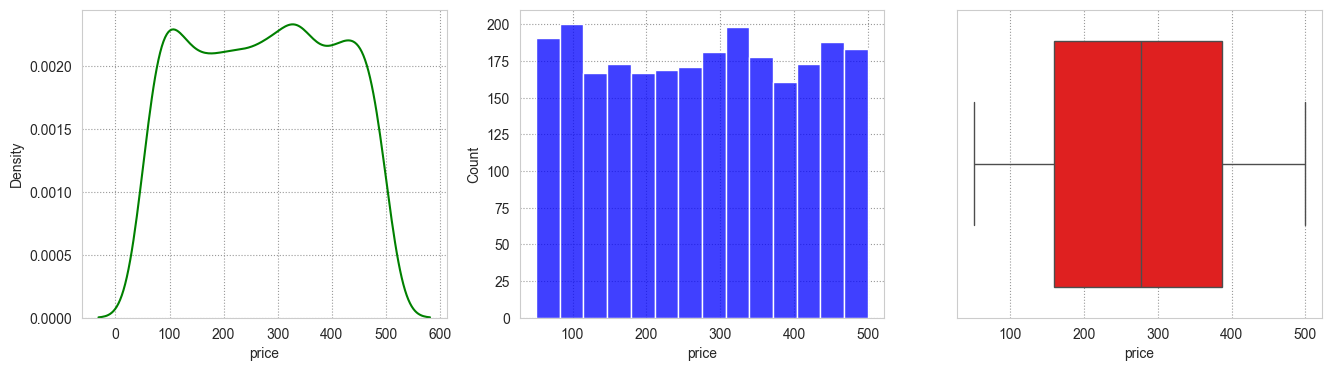

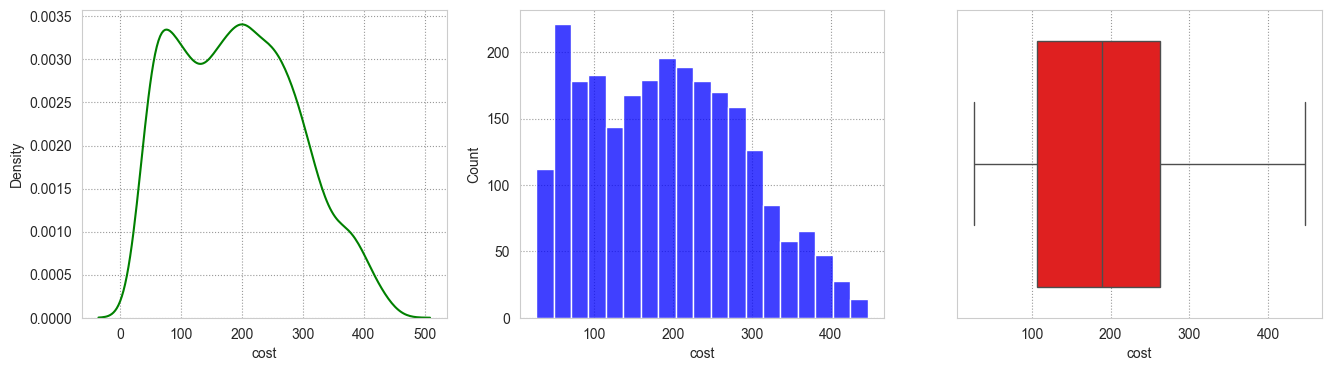

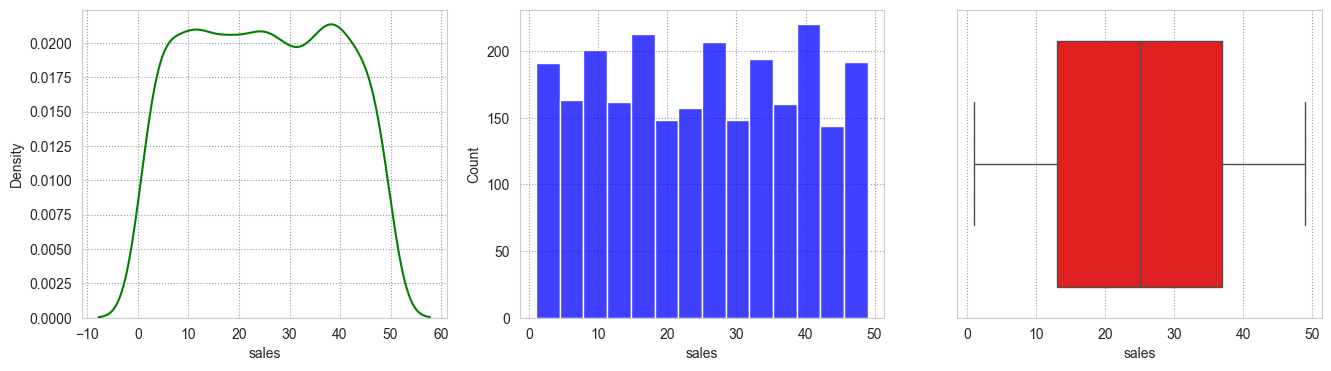

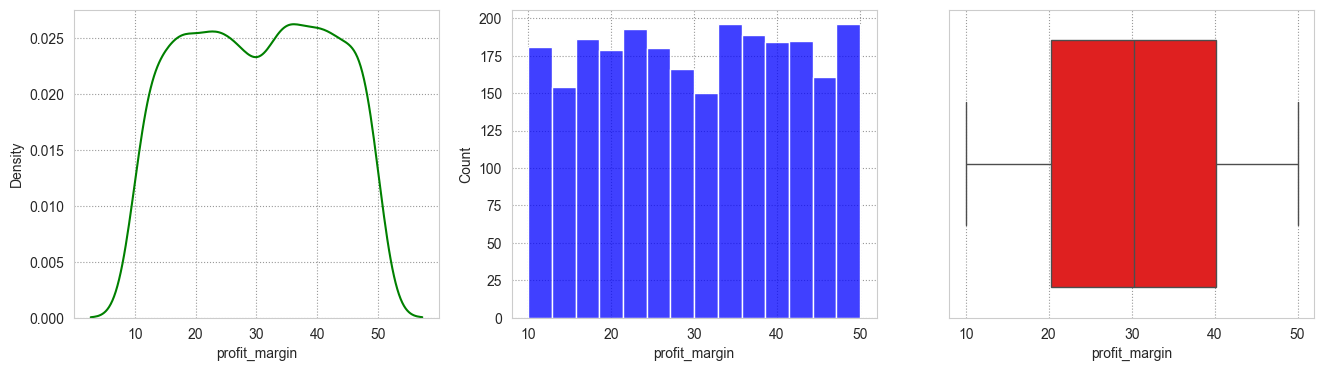

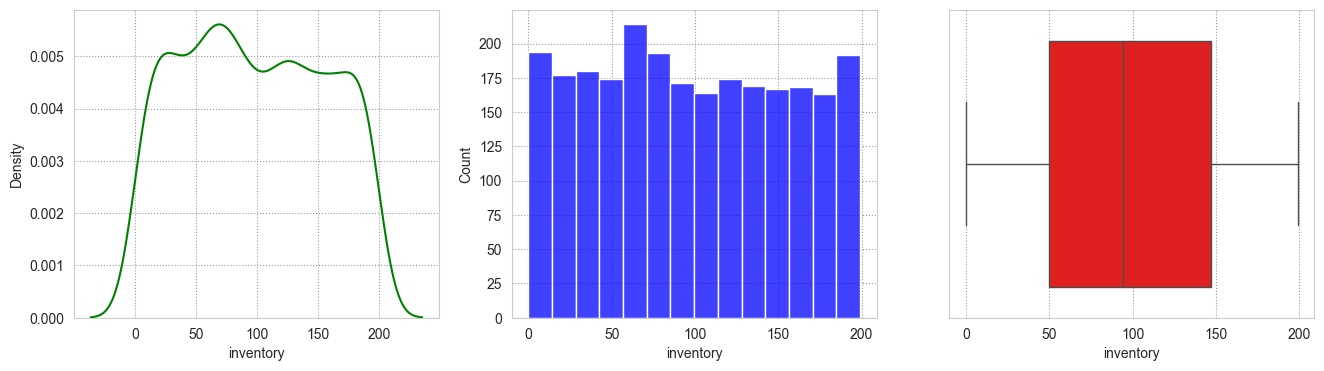

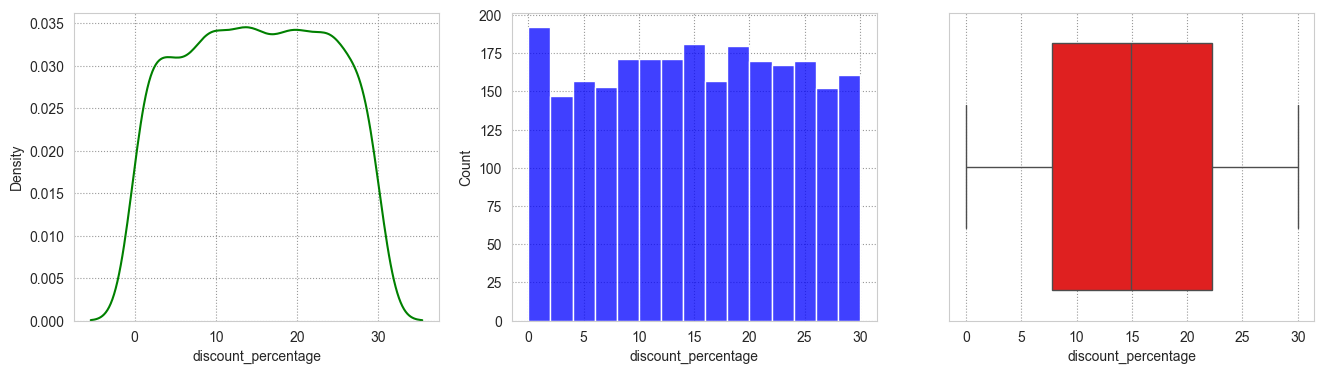

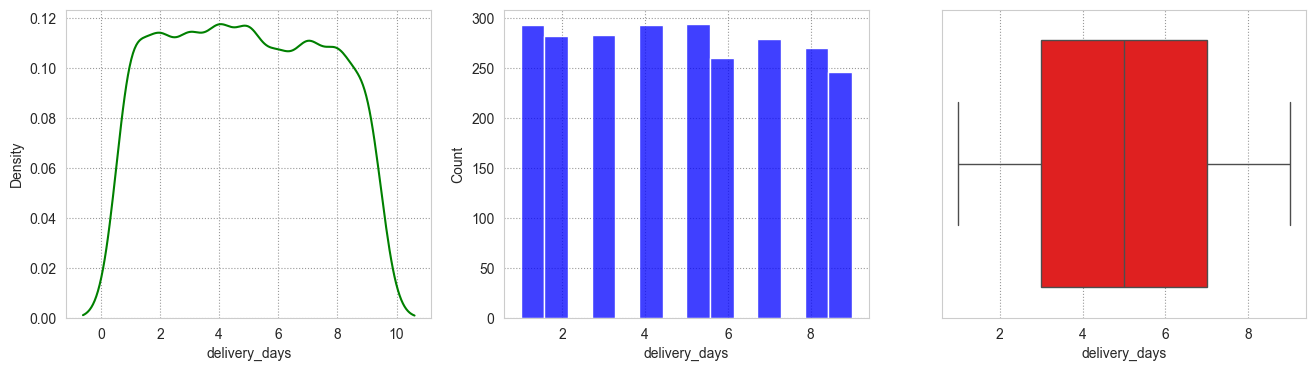

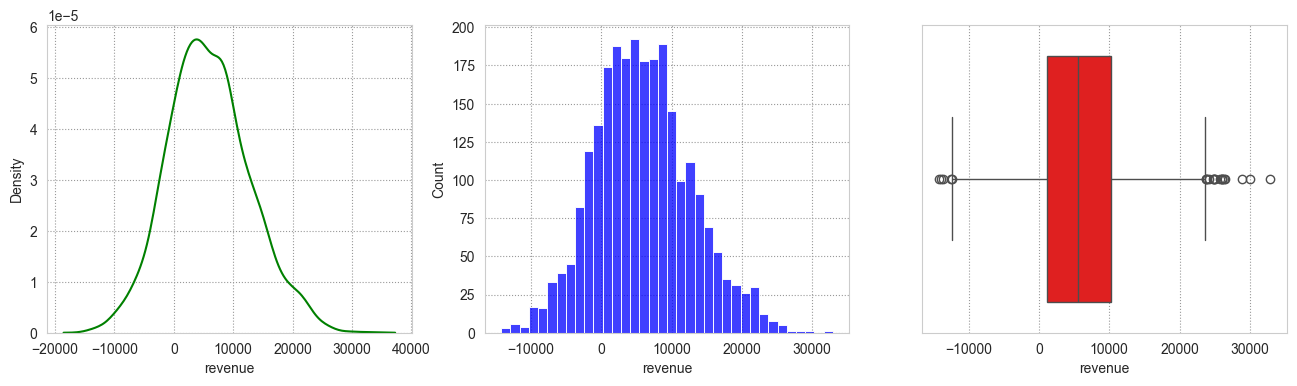

In [296]:
# Посмотрим на виды распределений "числовых" параметров и на ящики с усами
Drawer.plot_numeric_seaborn(df)

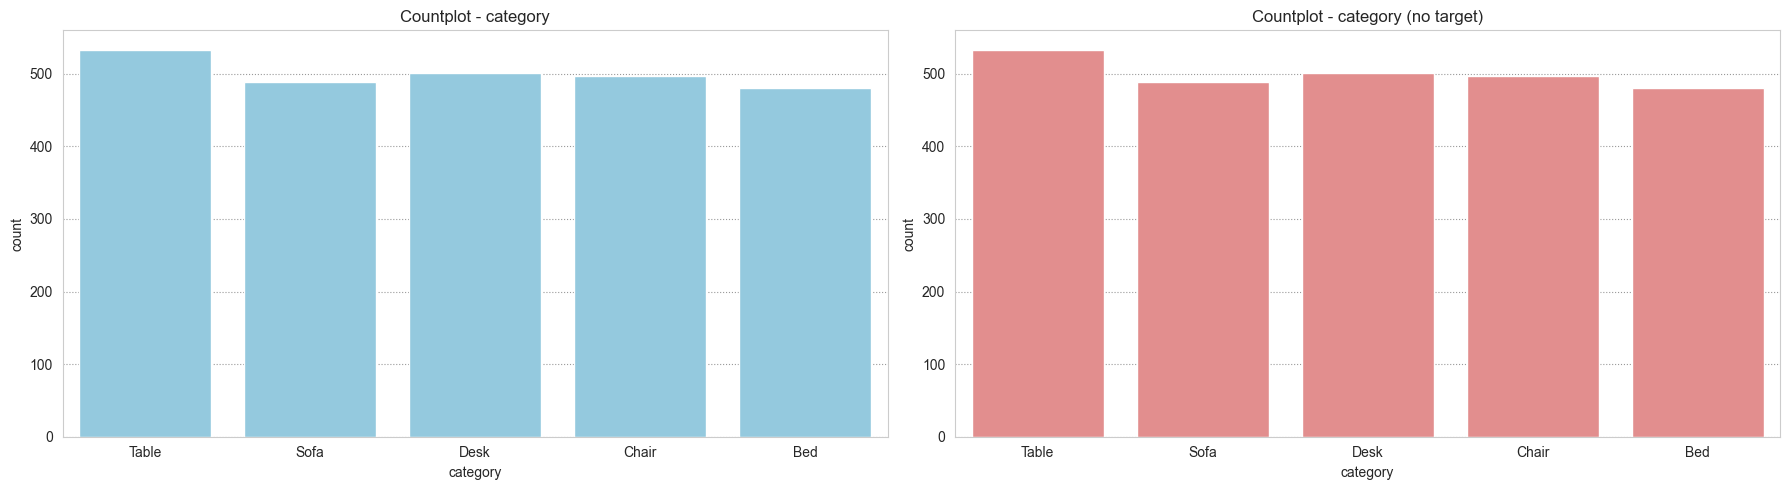

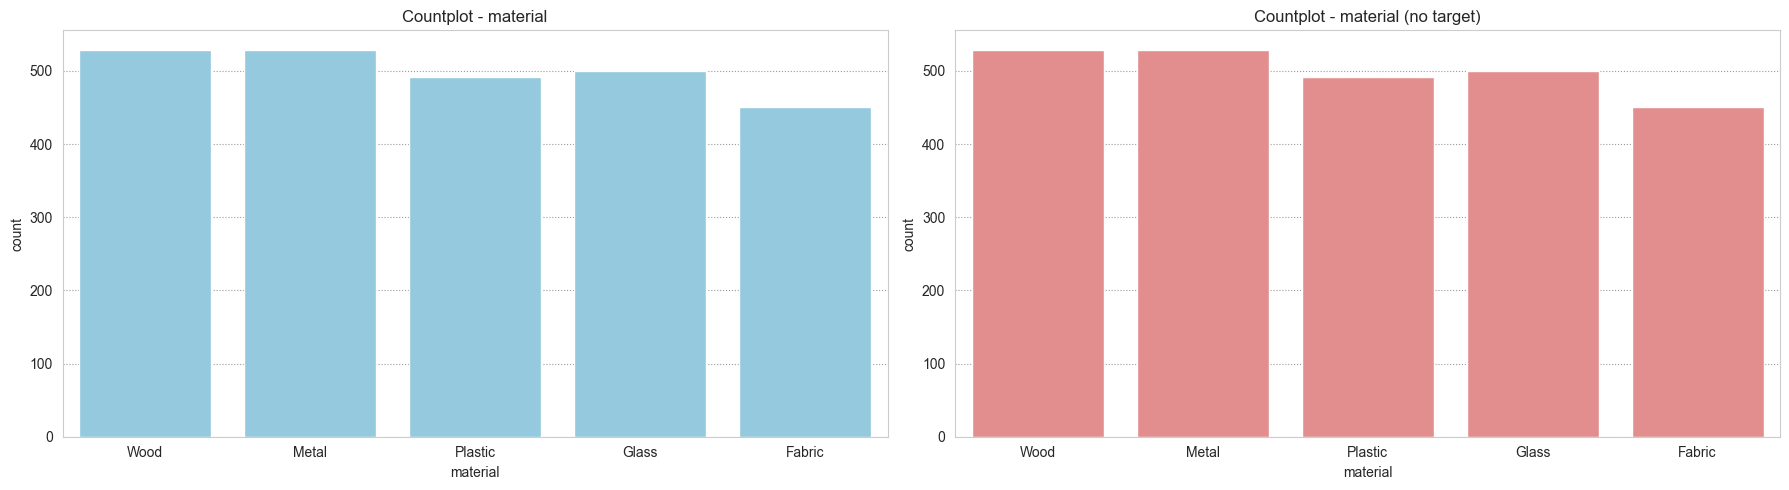

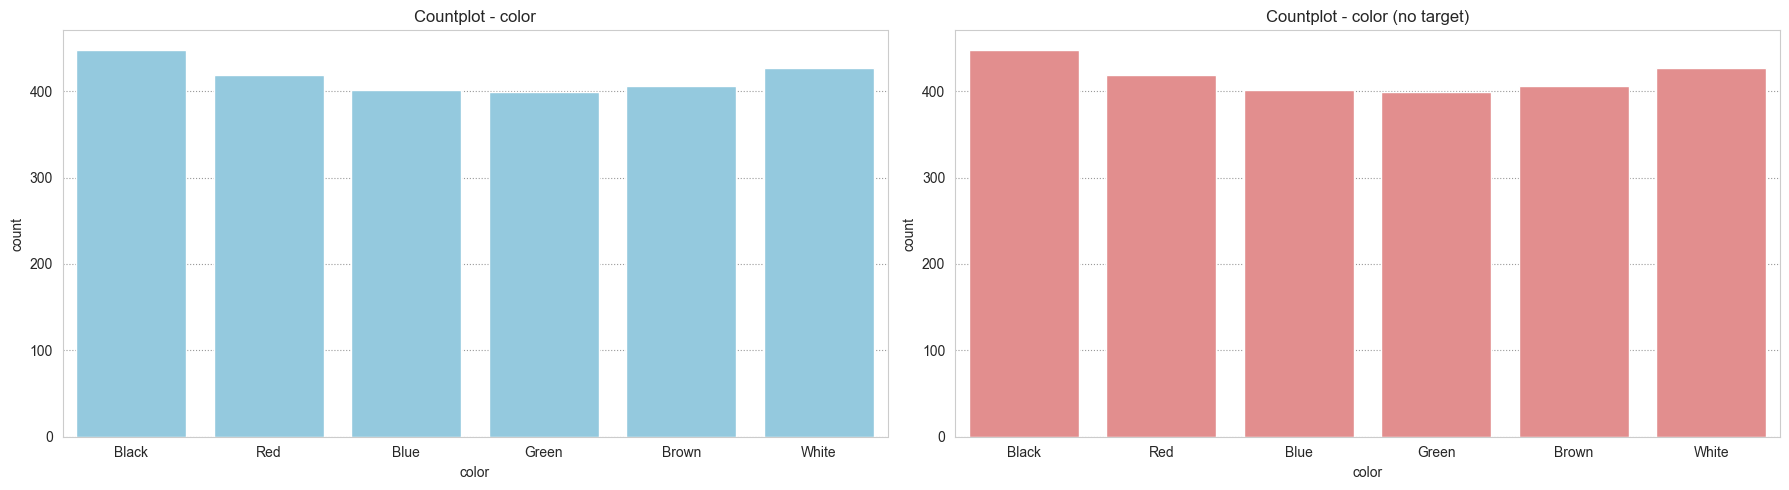

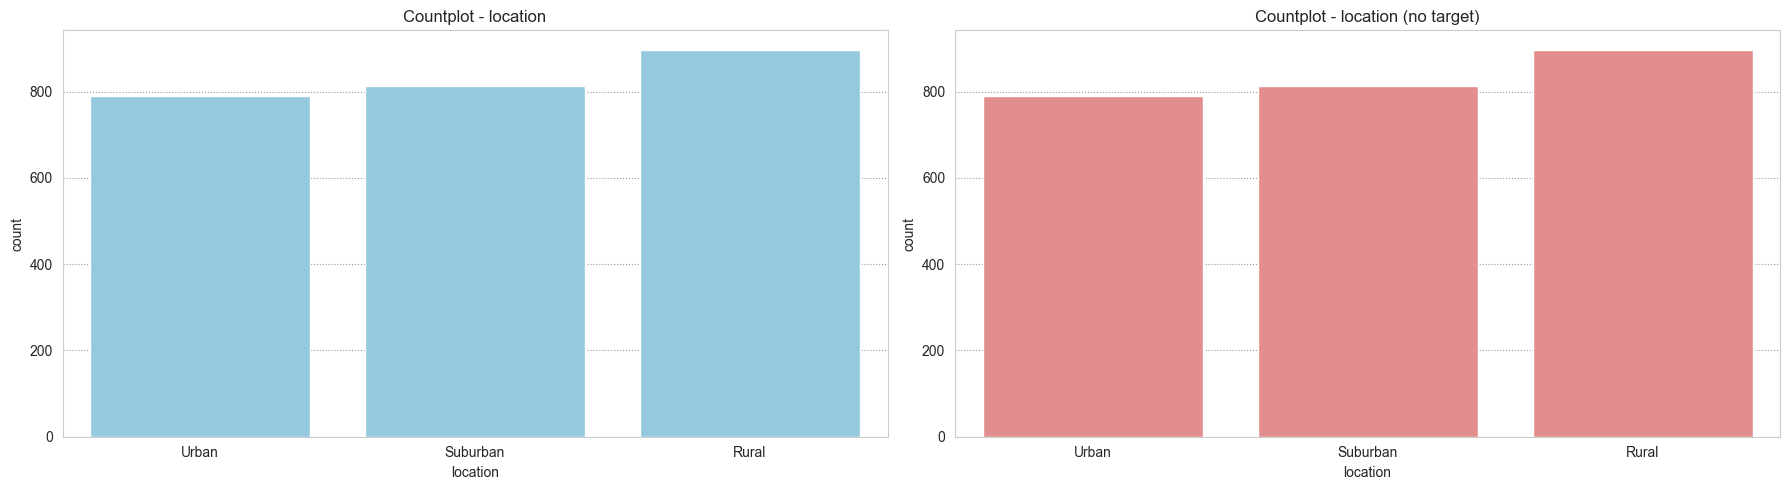

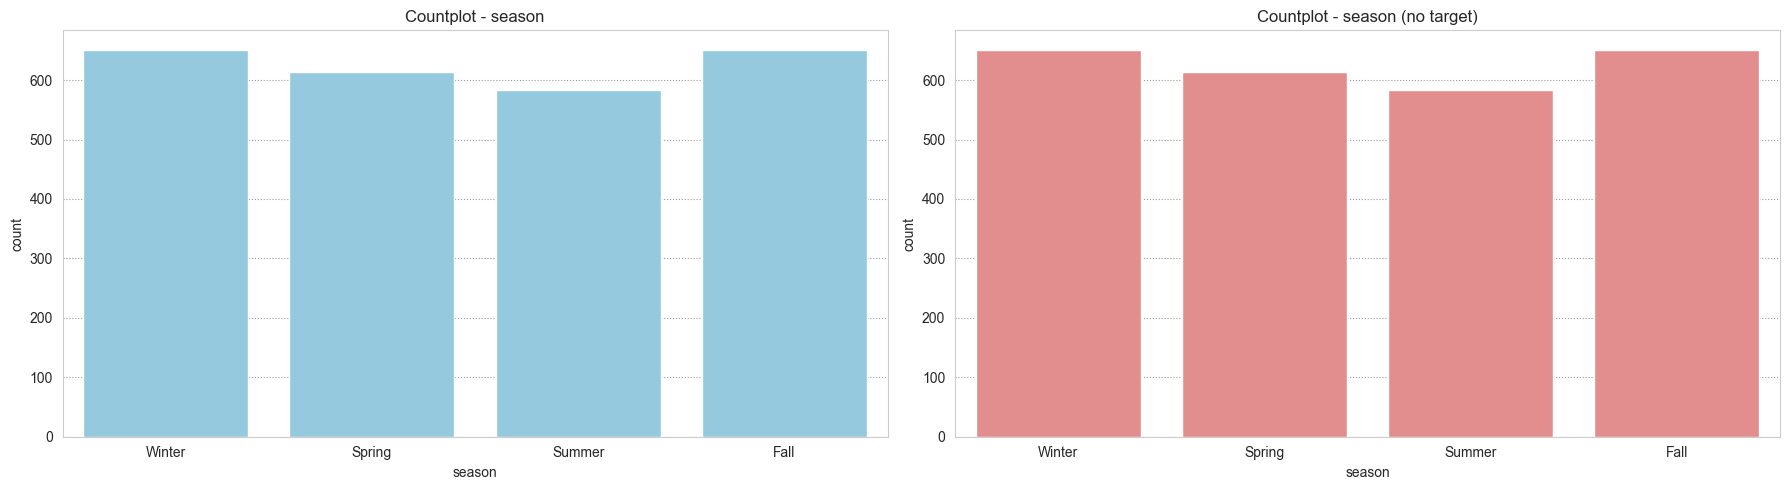

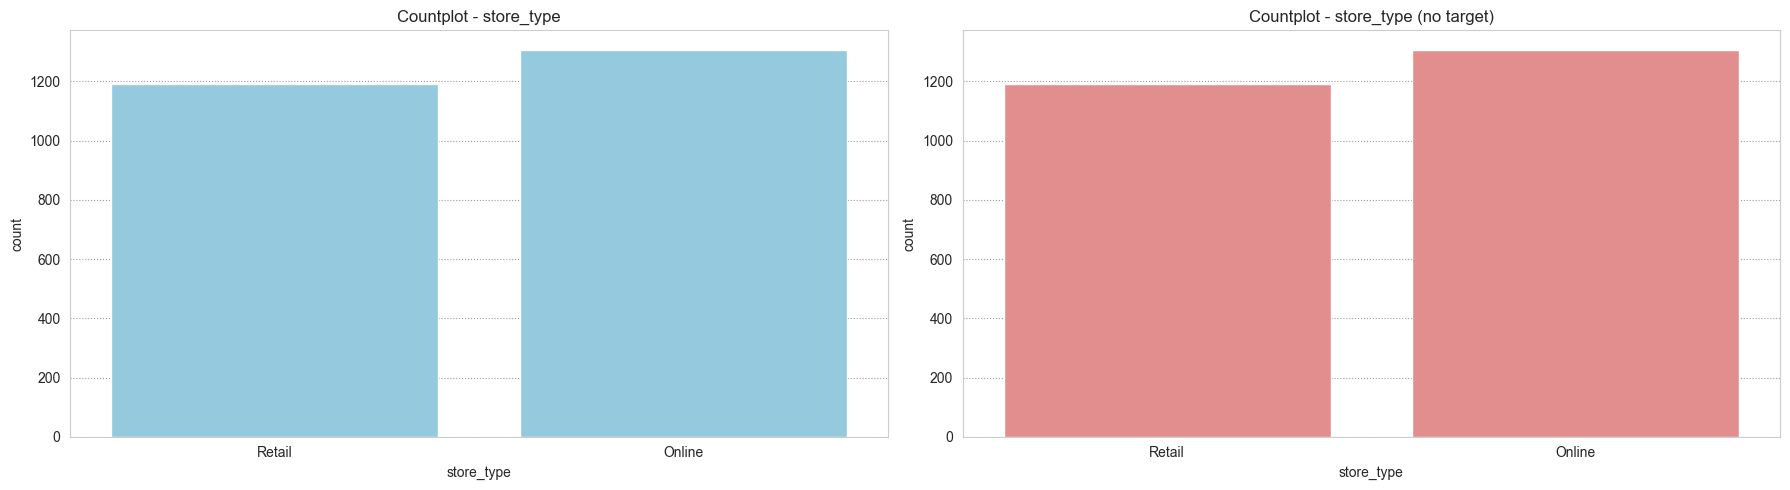

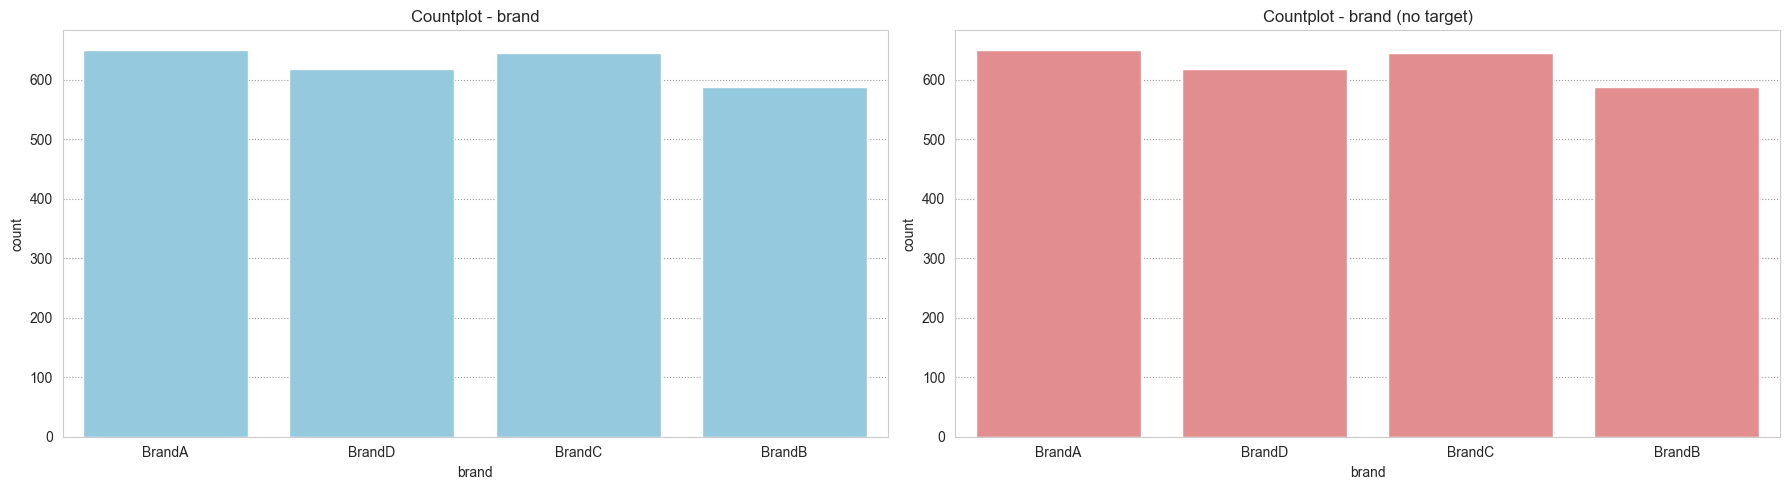

In [297]:
# Посмотрим на распределение категориальных величин
Drawer.plot_categorical_seaborn(df)

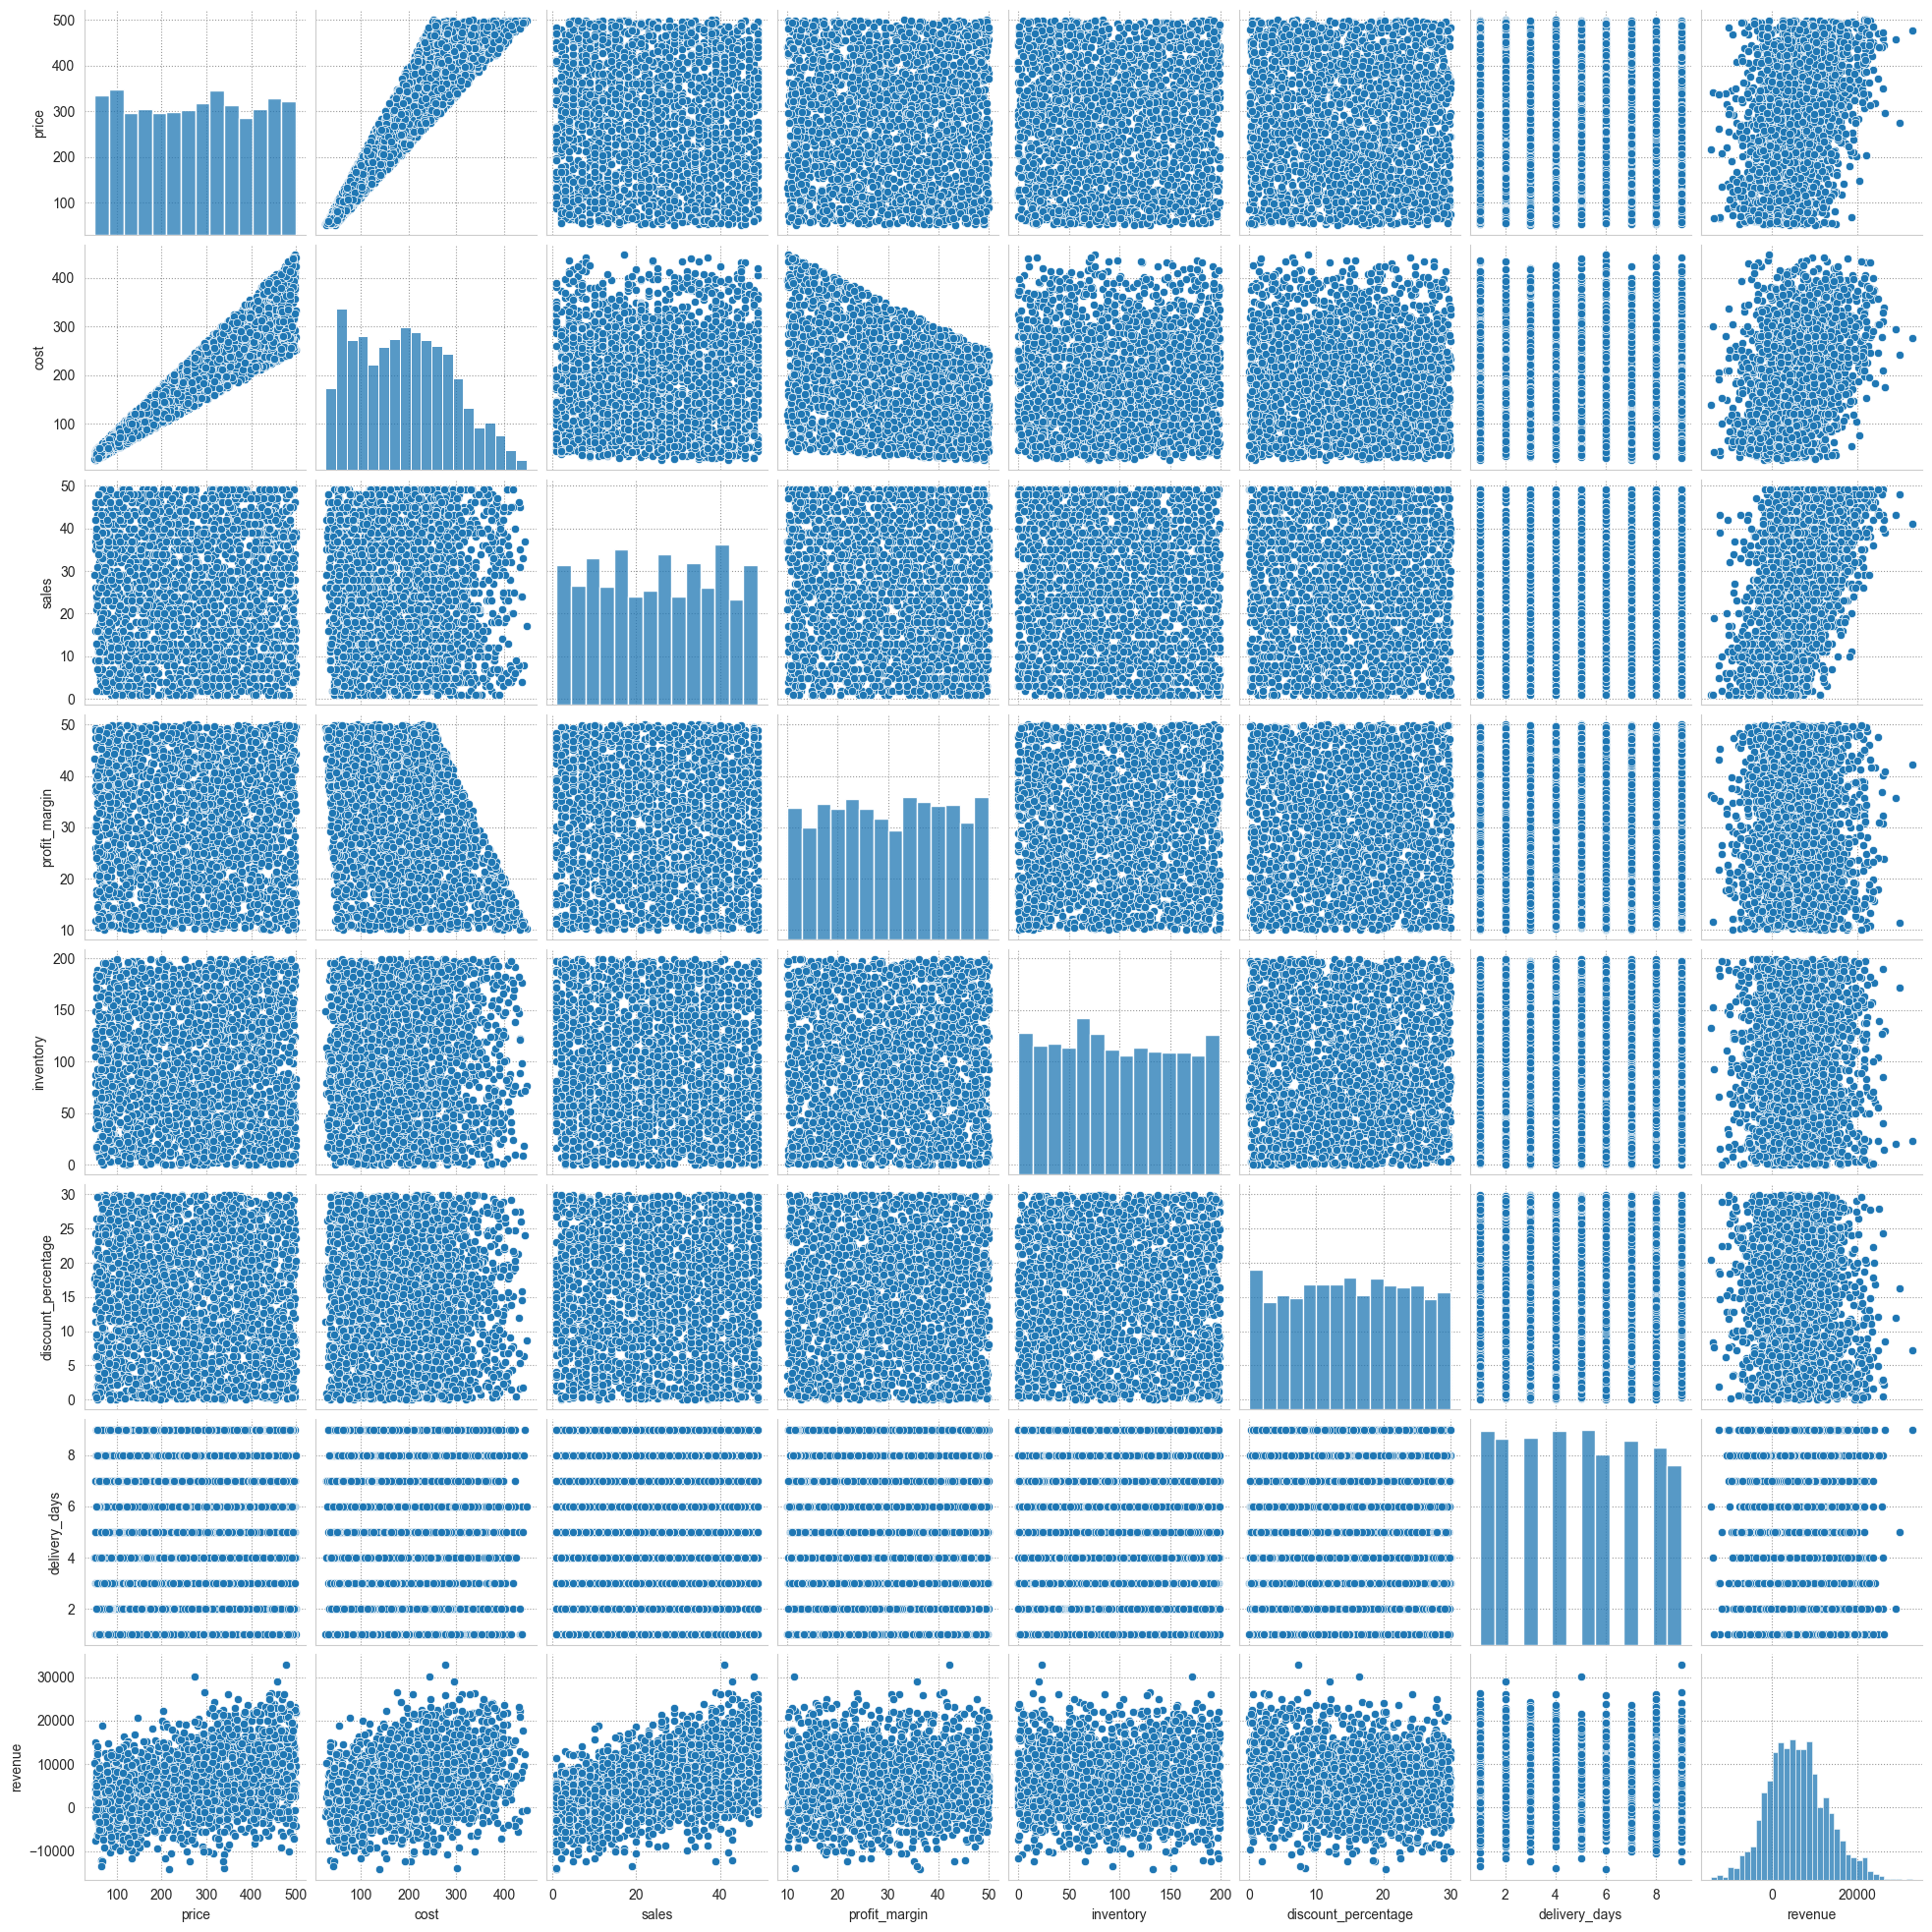

In [298]:
numeric_col = df.describe().columns
sns.pairplot(df[numeric_col])

Выводы:
1. cost и revenue имеют близкое к нормальному распределению
2. выше определённого значения cost начинает падает profit_margin
3. подозрения на прямую корреляцию price (таргета) от cost
4. распределения price и cost не равны 

# Проводим оценку зависимостей

## стат.обработка непрерывных данных

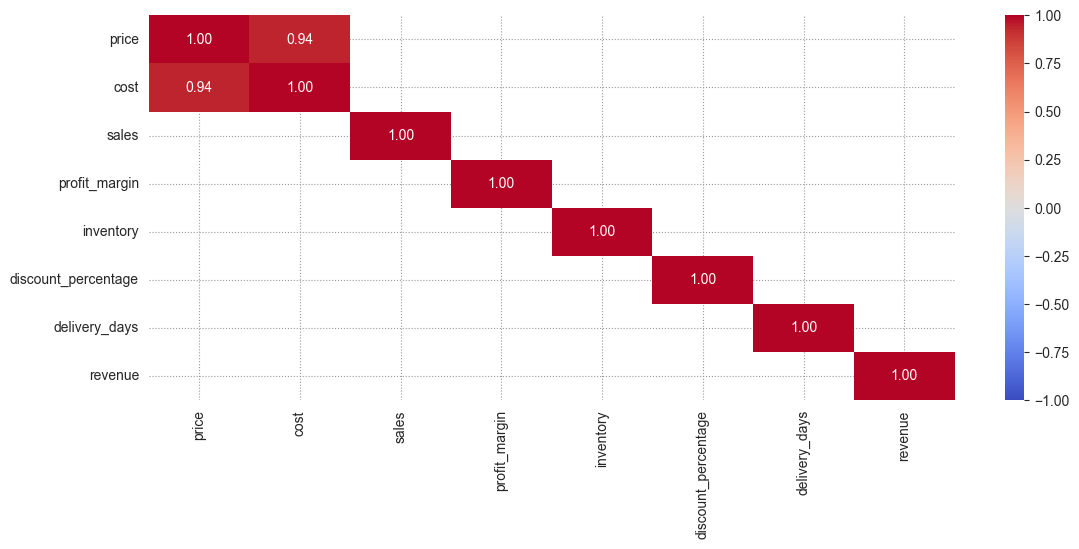

In [299]:
# Исследуем тепловую карту корреляции непрерывных признаков 
Drawer.plot_heatmap(df, method='spearman', boundary=0.5)

In [300]:
# проверяем распределения между таргетом и признаками
for column in df.select_dtypes(include='number').columns:
    print(f"{column} и price:")
    groups = [df[column], df['price']]
    StatCriteria().mannwhitneyu(groups)

price и price:
Mann-Whitney U test
U_statistic = 3125000.000
Распределения двух выборок равны (p-value = 1.000).
cost и price:
Mann-Whitney U test
U_statistic = 1987986.000
Распределения двух выборок не равны (p-value = 0.000).
sales и price:
Mann-Whitney U test
U_statistic = 0.000
Распределения двух выборок не равны (p-value = 0.000).
profit_margin и price:
Mann-Whitney U test
U_statistic = 0.000
Распределения двух выборок не равны (p-value = 0.000).
inventory и price:
Mann-Whitney U test
U_statistic = 778193.000
Распределения двух выборок не равны (p-value = 0.000).
discount_percentage и price:
Mann-Whitney U test
U_statistic = 0.000
Распределения двух выборок не равны (p-value = 0.000).
delivery_days и price:
Mann-Whitney U test
U_statistic = 0.000
Распределения двух выборок не равны (p-value = 0.000).
revenue и price:
Mann-Whitney U test
U_statistic = 4972244.000
Распределения двух выборок не равны (p-value = 0.000).


In [301]:
# Проверим допущение о мультиколлинеарности признаков
exclude_features = ['price']
StatCriteria().VIF(df, exclude_features)

VIF
cost                 4.416676
sales                4.864945
profit_margin        5.206018
inventory            3.584181
discount_percentage  3.675485
delivery_days        4.153730
revenue              2.707721

Выводы:
1. сильная положительная корреляция price и cost
2. profit_margin с VIF > 5 намекает на некоторую мультиколлениарность
3. распределения непрерывных признаков и таргета не совпадают

## стат.обработка категориальных данных

In [302]:
# Смотрим на колонки с категориальными переменными
df.describe(include='object')

category material  color location  season store_type   brand
count      2500     2500   2500     2500    2500       2500    2500
unique        5        5      6        3       4          2       4
top       Table    Metal  Black    Rural  Winter     Online  BrandA
freq        533      529    448      897     651       1307     650

Chi-square test
chisq_statistic = 10.426, dof = 16.000
Две переменные независимы (p-value = 0.843).
Chi-square test
chisq_statistic = 17.471, dof = 20.000
Две переменные независимы (p-value = 0.622).
Chi-square test
chisq_statistic = 5.572, dof = 8.000
Две переменные независимы (p-value = 0.695).
Chi-square test
chisq_statistic = 17.272, dof = 12.000
Две переменные независимы (p-value = 0.140).
Chi-square test
chisq_statistic = 7.275, dof = 4.000
Две переменные независимы (p-value = 0.122).
Chi-square test
chisq_statistic = 10.448, dof = 12.000
Две переменные независимы (p-value = 0.577).
Chi-square test
chisq_statistic = 10.426, dof = 16.000
Две переменные независимы (p-value = 0.843).
Chi-square test
chisq_statistic = 27.980, dof = 20.000
Две переменные независимы (p-value = 0.110).
Chi-square test
chisq_statistic = 13.374, dof = 8.000
Две переменные независимы (p-value = 0.100).
Chi-square test
chisq_statistic = 7.905, dof = 12.000
Две переменные независимы (p-value = 0.793).
Chi-sq

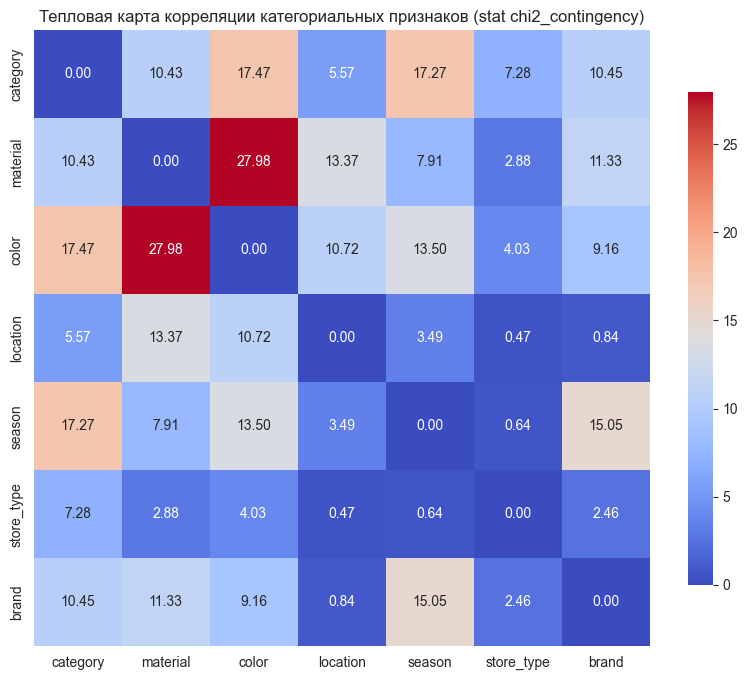

In [303]:
# Построим тепловую карту с категориальными переменными по хи-квадрат
Drawer.plot_heatmap_category(df)

Выводы:
1. небольшая зависимость категориальных признаков color и material
2. в категориальных данных нет большого числа уникальных значений
3. нет порядковых категориальных данных
4. store_type имеет два уникальных значения, можно использовать бинарную кодировку
5. season имеет циклические значения времён кода - циклическую кодировку
6. category, material, color, location, brand - подходят под one hot encoder

# Подготавливаем данные

In [304]:
# кодируем данные общего датасета
Encoder.booleanOneColumnEncoder(df['store_type'], 'Online')

0       0
1       0
2       1
3       0
4       0
       ..
2495    1
2496    1
2497    1
2498    0
2499    0
Name: store_type, Length: 2500, dtype: uint8

In [305]:
# разделяем данные
target = ['price']
exclude_features = ['price']
# exclude_features = ['price', 'inventory']  ## inventory - по Lasso

X_train, X_test, y_train, y_test = DataPreparation().train_test_split(df, exclude_features, target)

In [306]:
# кодируем категориальные данные в зависимости от таргета
categorical_features = df.select_dtypes(include='object').columns.tolist()
columns_for_encoding = [feature for feature in categorical_features if feature not in exclude_features]

X_train, X_test, _ = Encoder.oneHotEncoder(X_train, X_test, columns_for_encoding)
# X_train, X_test, _ = Encoder.targetEncoder(X_train, X_test, y_train, columns_for_encoding)

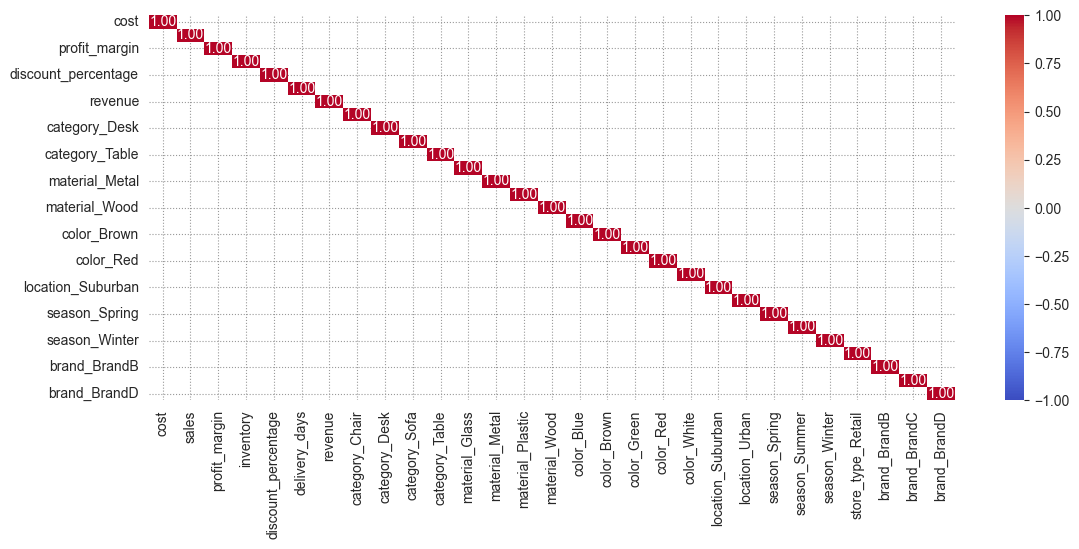

In [307]:
# Исследуем тепловую карту корреляции непрерывных признаков 
Drawer.plot_heatmap(X_train, method='spearman', boundary=0.5)

In [308]:
# проводим нормализацию
X_train, X_test, _ = Normalizer().MinMaxScaler(X_train, X_test)
y_train, y_test, scaler_y = Normalizer().MinMaxScaler(y_train, y_test)
X_train, X_test, y_train, y_test = Normalizer().reset_index(X_train, X_test, y_train, y_test)

Выводы:
1. кодировка произведена
2. тепловая карта корреляции после кодировки в порядке

# Строим модель

In [309]:
# Применим метод OLS
y_test, y_pred, _ = RegressionModel().OLS(X_train, X_test, y_train, y_test)

y_test_inv, y_pred_inv = MetricCalculator.inverse_transform(y_test, y_pred, scaler_y)
MetricCalculator.show_regression_metrics(y_test_inv, y_pred_inv)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     2271.
Date:                Sat, 08 Feb 2025   Prob (F-statistic):               0.00
Time:                        05:19:40   Log-Likelihood:                 3029.6
No. Observations:                1875   AIC:                            -5999.
Df Residuals:                    1845   BIC:                            -5833.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
cost                    1.2970    

In [310]:
residuals = y_test - y_pred
StatCriteria().shapiro(residuals)

Shapiro-Wilk Test
statistic = 0.992
Данные не соответствуют нормальному распределению (p-value = 0.001).


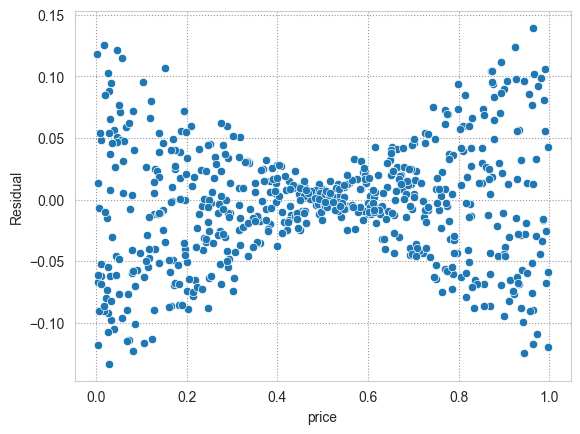

In [311]:
# Проверка на гомоскедастичность визуально
sns.scatterplot(x = y_test.squeeze(), y = residuals.squeeze())
plt.ylabel("Residual")
plt.show()

In [312]:
# Применим метод Lasso
y_test, y_pred, _ = RegressionModel().Lasso(X_train, X_test, y_train, y_test)

y_test_inv, y_pred_inv = MetricCalculator.inverse_transform(y_test, y_pred, scaler_y)
MetricCalculator.show_regression_metrics(y_test_inv, y_pred_inv)

__________
Коэффициенты Lasso-регрессии:
cost: 1.05
sales: -0.00
profit_margin: 0.16
inventory: 0.00
discount_percentage: -0.00
delivery_days: -0.00
revenue: 0.00
category_Chair: -0.00
category_Desk: 0.00
category_Sofa: -0.00
category_Table: -0.00
material_Glass: -0.00
material_Metal: -0.00
material_Plastic: -0.00
material_Wood: 0.00
color_Blue: 0.00
color_Brown: -0.00
color_Green: -0.00
color_Red: 0.00
color_White: 0.00
location_Suburban: 0.00
location_Urban: -0.00
season_Spring: 0.00
season_Summer: 0.00
season_Winter: -0.00
store_type_Retail: -0.00
brand_BrandB: -0.00
brand_BrandC: 0.00
brand_BrandD: 0.00
R²: 0.928
MAE: 28.24
MAPE: 17%
RMSE: 35
MSE: 1228


In [313]:
# Применим метод опорных векторов
y_test, y_pred, _ = RegressionModel().SVR(X_train, X_test, y_train, y_test, kernel='rbf', C=1.0, epsilon=0.01)

y_test_inv, y_pred_inv = MetricCalculator.inverse_transform(y_test, y_pred, scaler_y)
MetricCalculator.show_regression_metrics(y_test_inv, y_pred_inv)

R²: 0.982
MAE: 13.49
MAPE: 8%
RMSE: 18
MSE: 312


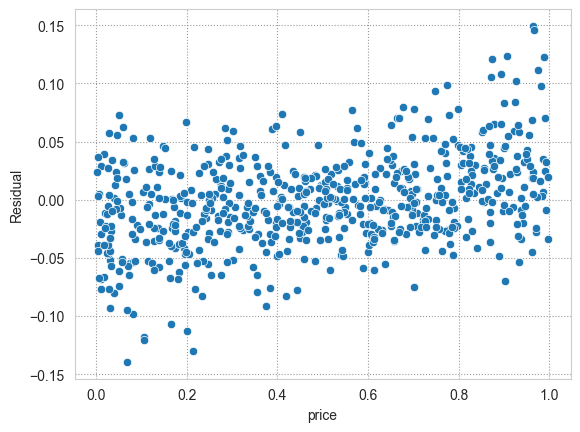

In [314]:
residuals = y_test - y_pred
# Проверка на гомоскедастичность визуально
sns.scatterplot(x = y_test.squeeze(), y = residuals.squeeze())
plt.ylabel("Residual")
plt.show()

Epoch 1/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - R2Score: -0.8183 - loss: 0.1604 - val_R2Score: 0.3659 - val_loss: 0.0538
Epoch 2/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - R2Score: 0.5203 - loss: 0.0410 - val_R2Score: 0.7385 - val_loss: 0.0222
Epoch 3/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - R2Score: 0.8142 - loss: 0.0162 - val_R2Score: 0.8695 - val_loss: 0.0111
Epoch 4/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - R2Score: 0.8885 - loss: 0.0096 - val_R2Score: 0.9065 - val_loss: 0.0079
Epoch 5/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - R2Score: 0.9245 - loss: 0.0064 - val_R2Score: 0.9246 - val_loss: 0.0064
Epoch 6/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - R2Score: 0.9411 - loss: 0.0049 - val_R2Score: 0.9401 - val_loss: 0.0051
Epoch 7/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - R2Score: 0.9510 - loss: 0.0040 - val_R2Score: 0.9513 - val_loss: 0.0041
Epoch 8/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - R2Score: 0.9569 - loss: 0.0037 - val_R2Sc

<Axes: >

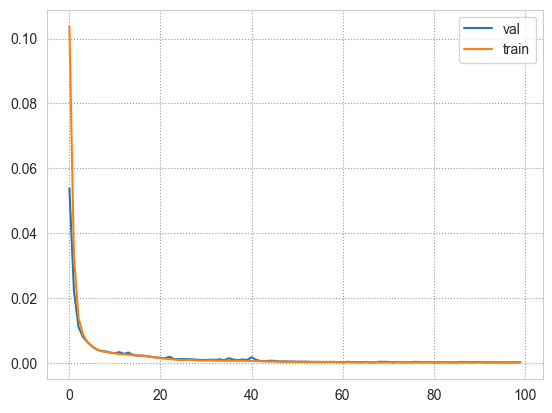

In [317]:
# Создание модели
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1)) 

# Компиляция модели
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['R2Score'])

# Обучение модели
epochs = 100
batch_size=8
history = model.fit(X_train, y_train,
                    epochs=epochs, batch_size=batch_size,
                    validation_data=(X_test, y_test))

# выводим графики
sns.lineplot(y=history.history['val_loss'], x=np.arange(epochs), label='val')
sns.lineplot(y=history.history['loss'], x=np.arange(epochs), label='train')
#history.history['val_loss']

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


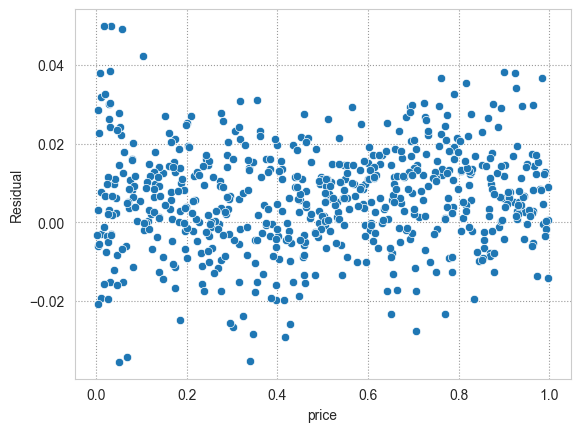

In [318]:
y_pred = model.predict(X_test)
residuals = y_test - y_pred
# Проверка на гомоскедастичность визуально
sns.scatterplot(x = y_test.squeeze(), y = residuals.squeeze())
plt.ylabel("Residual")
plt.show()